In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import re
from collections import Counter

In [2]:
clickstream = pd.read_csv('clickstream.csv')
nps = pd.read_csv('nps_feedback.csv')



In [3]:
print(f"Total number of unique users: {clickstream['user_id'].nunique()}")
print(f"Total number of sessions: {clickstream['session_id'].nunique()}")
print(f"Total number of clicks: {len(clickstream)}")

Total number of unique users: 1000
Total number of sessions: 2490
Total number of clicks: 29215


In [4]:
top_pages = clickstream['page'].value_counts()
print("Top 5 pages visited by users:\n",top_pages.head(5))

Top 5 pages visited by users:
 page
/home       4251
/login      4188
/reports    4176
/help       4172
/billing    4168
Name: count, dtype: int64


In [5]:
top_actions = clickstream['action_type'].value_counts()
print("Top 5 actions performed by users:\n",top_actions.head(5))

Top 5 actions performed by users:
 action_type
hover           5969
form_submit     5902
nav_click       5806
click_button    5782
scroll          5756
Name: count, dtype: int64


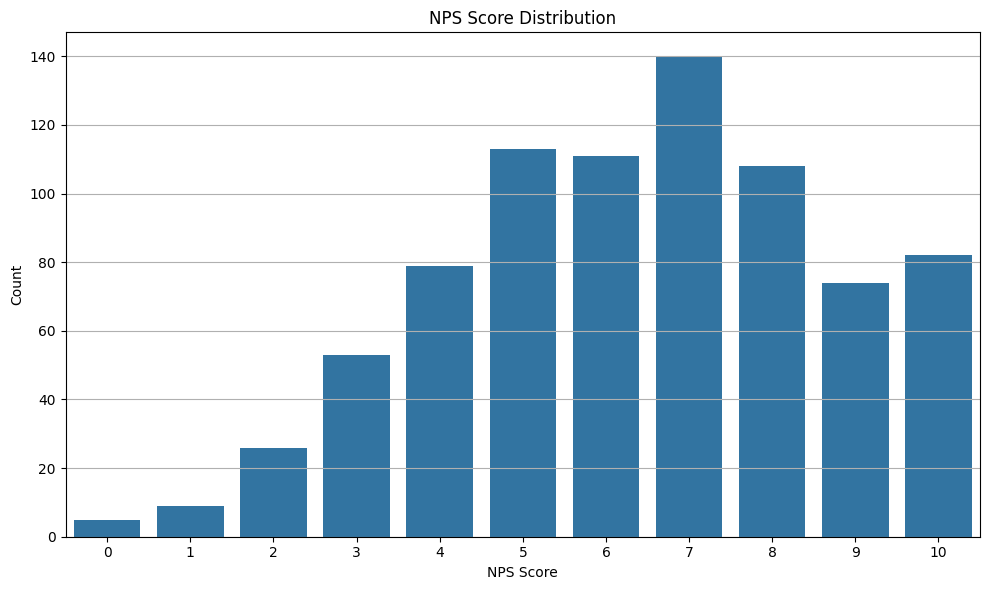

In [6]:
#working on some insights from nps data

#nps score distribution

plt.figure(figsize=(10,6))
sns.countplot(x='nps_score',data=nps)
plt.title('NPS Score Distribution')
plt.xlabel('NPS Score')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count')

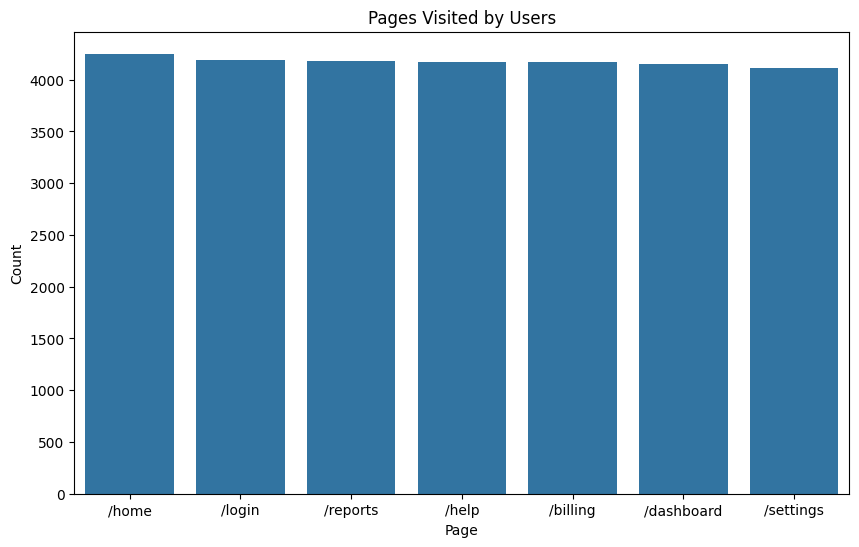

In [7]:
#top pages visited visualization

plt.figure(figsize=(10,6))
sns.barplot(x = top_pages.index, y=top_pages.values)
plt.title('Pages Visited by Users')
plt.xlabel('Page')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

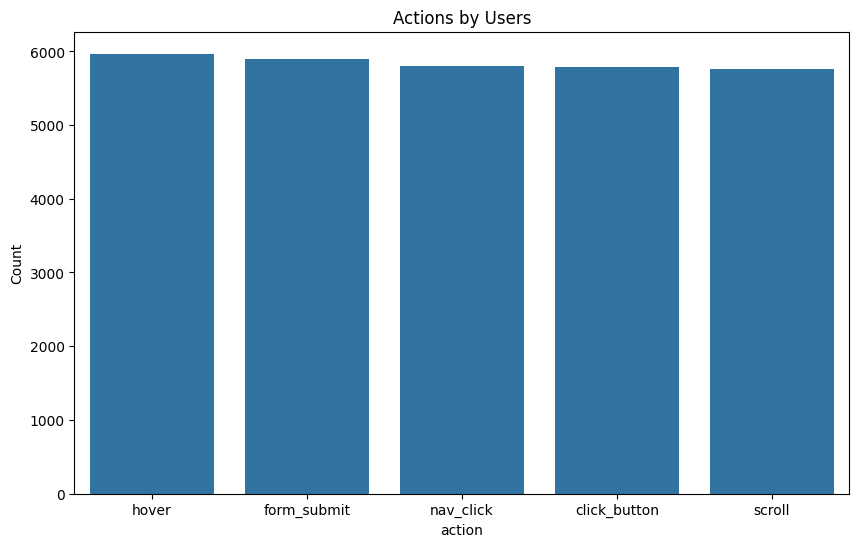

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x = top_actions.index, y=top_actions.values)
plt.title('Actions by Users')
plt.xlabel('action')
plt.ylabel('Count')

In [9]:
#generating wordcloud for nps feedback

feedback_text = " ".join(nps['feedback_text'].dropna().tolist()).lower()

In [13]:
nltk.download('punkt_tab',download_dir= './nltk_data')
nltk.download('stopwords', download_dir= './nltk_data')
nltk.data.path.append('./nltk_data')

[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
stop_words = set(nltk.corpus.stopwords.words('english'))

Text(0.5, 1.0, 'Word Cloud of NPS Feedback')

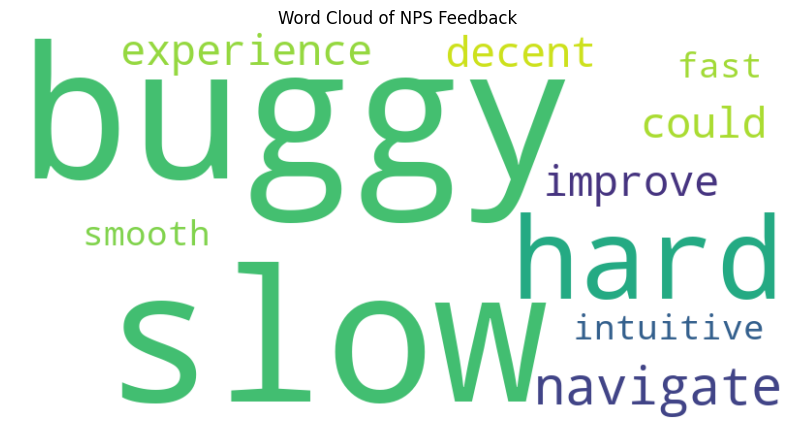

In [15]:
tokens = nltk.tokenize.word_tokenize(feedback_text)

filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
word_freq = Counter(filtered_tokens)

wordcloud = WordCloud(width = 800, height = 400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.title("Word Cloud of NPS Feedback")

In [16]:
#Feature Engineering and Model building for early churn prediction

#feature 1: number of sessions per user
sessions_per_user = clickstream.groupby('user_id')['session_id'].nunique().reset_index(name='num_of_sessions')

#feature 2: Total number of events/clicks per user
events_per_user = clickstream.groupby('user_id')['action_type'].size().reset_index(name='num_of_events')

#feature 3: average time per event for a user
avg_duration_per_event = clickstream.groupby('user_id')['duration_sec'].mean().reset_index(name='avg_duration_per_event')

#feature 4: most visited page for a user
most_visited_page = (clickstream.groupby(['user_id','page']).size().reset_index(name='page_count')
                     .sort_values(['user_id','page_count'],ascending = [True,False])
                     .drop_duplicates('user_id')[['user_id','page']])

#feature 5: all action counts for a user
action_counts = (
    clickstream.groupby(['user_id','action_type']).size().reset_index(name='action_count')
    .pivot(index='user_id',columns='action_type',values='action_count').fillna(0).reset_index()
)
action_counts.columns.name = None

#merging all features into a df

user_features = (
    sessions_per_user
    .merge(events_per_user,on='user_id')
    .merge(avg_duration_per_event,on='user_id')
    .merge(most_visited_page,on='user_id')
    .merge(action_counts,on='user_id')
)

user_features

,user_id,num_of_sessions,num_of_events,avg_duration_per_event,page,click_button,form_submit,hover,nav_click,scroll
0,u0001,1,9,25.666667,/home,2.0,2.0,0.0,1.0,4.0
1,u0002,1,6,50.333333,/reports,2.0,1.0,0.0,3.0,0.0
2,u0003,1,9,31.444444,/dashboard,1.0,3.0,2.0,2.0,1.0
3,u0004,4,42,35.809524,/dashboard,12.0,8.0,9.0,3.0,10.0
4,u0005,4,40,32.875000,/home,7.0,9.0,7.0,10.0,7.0
...,...,...,...,...,...,...,...,...,...,...
995,u0996,4,41,32.097561,/reports,11.0,9.0,8.0,5.0,8.0
996,u0997,4,36,29.111111,/billing,7.0,10.0,6.0,7.0,6.0
997,u0998,3,29,35.931034,/reports,4.0,6.0,8.0,6.0,5.0
998,u0999,4,35,31.971429,/settings,8.0,4.0,7.0,7.0,9.0


In [18]:
#label encoding most visited page
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

user_features['encoded_frequent_page'] = le.fit_transform(user_features['page'])

user_features.drop(columns=['page'],inplace=True)
user_features.head()

,user_id,num_of_sessions,num_of_events,avg_duration_per_event,click_button,form_submit,hover,nav_click,scroll,encoded_frequent_page
0,u0001,1,9,25.666667,2.0,2.0,0.0,1.0,4.0,3
1,u0002,1,6,50.333333,2.0,1.0,0.0,3.0,0.0,5
2,u0003,1,9,31.444444,1.0,3.0,2.0,2.0,1.0,1
3,u0004,4,42,35.809524,12.0,8.0,9.0,3.0,10.0,1
4,u0005,4,40,32.875000,7.0,9.0,7.0,10.0,7.0,3


In [19]:
# engineering labels for data using nps

#NPS categories -> detractors, passives, promoters

def nps_category(score):
    if score <=6:
        return 'detractor'
    elif score <=8:
        return 'passive'
    else:
        return 'promoter'
    
nps['category_nps'] = nps['nps_score'].apply(nps_category)

In [22]:
import textblob

nps['sentiment'] = nps['feedback_text'].apply(lambda x: textblob.TextBlob(x).sentiment.polarity)
nps['timestamp'] = pd.to_datetime(nps['timestamp'])
nps

,user_id,timestamp,nps_score,feedback_text,category_nps,sentiment
0,u0958,2025-03-06 03:54:33,8,Decent experience but could improve.,passive,0.166667
1,u0744,2025-03-25 17:33:36,6,"Too slow, buggy or hard to navigate.",detractor,-0.295833
2,u0390,2025-03-28 18:54:21,8,Decent experience but could improve.,passive,0.166667
3,u0542,2025-03-25 22:04:30,10,"Very smooth, fast, and intuitive!",promoter,0.385000
4,u0085,2025-03-09 00:11:40,6,"Too slow, buggy or hard to navigate.",detractor,-0.295833
...,...,...,...,...,...,...
795,u0489,2025-03-13 15:11:19,9,"Very smooth, fast, and intuitive!",promoter,0.385000
796,u0863,2025-03-05 18:42:23,6,"Too slow, buggy or hard to navigate.",detractor,-0.295833
797,u0401,2025-03-20 05:29:02,8,Decent experience but could improve.,passive,0.166667
798,u0896,2025-03-15 20:50:25,7,Decent experience but could improve.,passive,0.166667


In [25]:
user_features = user_features.merge(nps[['user_id','feedback_text','sentiment','category_nps']],how = 'inner', on = 'user_id')

In [63]:
user_features.columns

user_features.to_csv('user_features.csv')

In [53]:
X = user_features[
    [
        'num_of_sessions',
        'num_of_events',
        'avg_duration_per_event',
        'encoded_frequent_page',
        'sentiment',
        'click_button',
        'form_submit',
        'hover',
        'nav_click',
        'scroll'
    ]
]

X_behaviour_only = X.drop(columns=['sentiment'])

y = user_features['category_nps']
y = le.fit_transform(y)

In [58]:
#Model Building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)


In [59]:
rfclassifier = RandomForestClassifier(n_estimators = 1, random_state= 42)
rfclassifier.fit(X_train, y_train)

y_pred = rfclassifier.predict(X_test)

print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Accuracy_score: 0.9875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       0.98      0.98      0.98        50
           2       0.97      0.97      0.97        31

    accuracy                           0.99       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.99      0.99      0.99       160

[[79  0  0]
 [ 0 49  1]
 [ 0  1 30]]


In [60]:
#training with behaviour only data without feedback text from users
X_train, X_test, y_train, y_test = train_test_split(X_behaviour_only, y, test_size = 0.2, random_state = 42, stratify=y)
rfclassifier1 = RandomForestClassifier(n_estimators = 500, random_state= 42)
rfclassifier1.fit(X_train, y_train)
y_pred = rfclassifier1.predict(X_test)
print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy_score: 0.46875
              precision    recall  f1-score   support

           0       0.49      0.76      0.60        79
           1       0.42      0.28      0.34        50
           2       0.20      0.03      0.06        31

    accuracy                           0.47       160
   macro avg       0.37      0.36      0.33       160
weighted avg       0.41      0.47      0.41       160



We can see that accuracy is very good when we use feedback text sentiment as on of the features in our model. This is an insight that in real world, we can predict the user net promoter score with high accuracy if we had feedback text from users about our product. But this is not ideal as we want to deal with people who never used our product and intervene early if we predict that they are in distractor category. But NPS data is a gamechanger in our business problem, when we want to finetune to our existing customers who gave feedback before. We can further see below in feature importance that all the heavy lifting is being done by the sentiment feature we engineered from feedback text. 

In [62]:
#finding feature importances

importances = rfclassifier.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance':importances
}).sort_values('importance',ascending=False)

feature_importances

,feature,importance
4,sentiment,0.907704
1,num_of_events,0.027916
9,scroll,0.019243
7,hover,0.016298
5,click_button,0.007730
2,avg_duration_per_event,0.007138
6,form_submit,0.005851
3,encoded_frequent_page,0.004372
8,nav_click,0.003747
0,num_of_sessions,0.000000


<Figure size 1000x600 with 0 Axes>

With more rich clickstream data like time on each screen, page revisits, scroll depth, etc, which can be collected from real website, we will be able to predict user nps with more accuracy. With little data, we have seen that the accuracy has increased from 33% to 48% 